In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import locale
from unidecode import unidecode

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test_x.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65125 entries, 0 to 65124
Data columns (total 44 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Basvuru Yili                                               65125 non-null  int64  
 1   Degerlendirme Puani                                        65124 non-null  float64
 2   Cinsiyet                                                   64956 non-null  object 
 3   Dogum Tarihi                                               64948 non-null  object 
 4   Dogum Yeri                                                 64334 non-null  object 
 5   Ikametgah Sehri                                            63088 non-null  object 
 6   Universite Adi                                             64993 non-null  object 
 7   Universite Turu                                            64870 non-null  object 
 8   Burslu

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11049 entries, 0 to 11048
Data columns (total 43 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Basvuru Yili                                               11049 non-null  int64  
 1   Cinsiyet                                                   11049 non-null  object 
 2   Dogum Tarihi                                               11049 non-null  object 
 3   Dogum Yeri                                                 11049 non-null  object 
 4   Ikametgah Sehri                                            11049 non-null  object 
 5   Universite Adi                                             11049 non-null  object 
 6   Universite Turu                                            11049 non-null  object 
 7   Burslu ise Burs Yuzdesi                                    0 non-null      float64
 8   Burs A

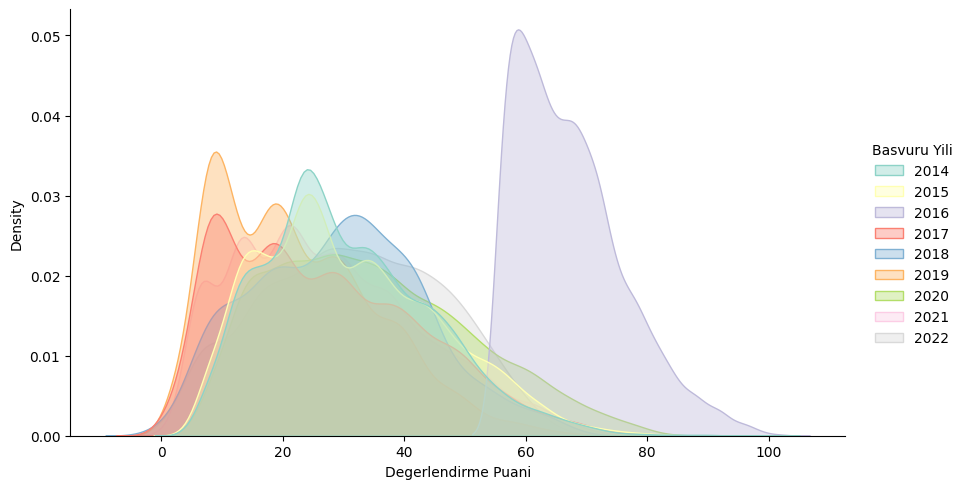

In [5]:
sns.displot(kind='kde', data=train, x="Degerlendirme Puani", hue="Basvuru Yili", height=5, aspect=1.75, fill=True, common_norm=False, alpha=0.4, palette="Set3")

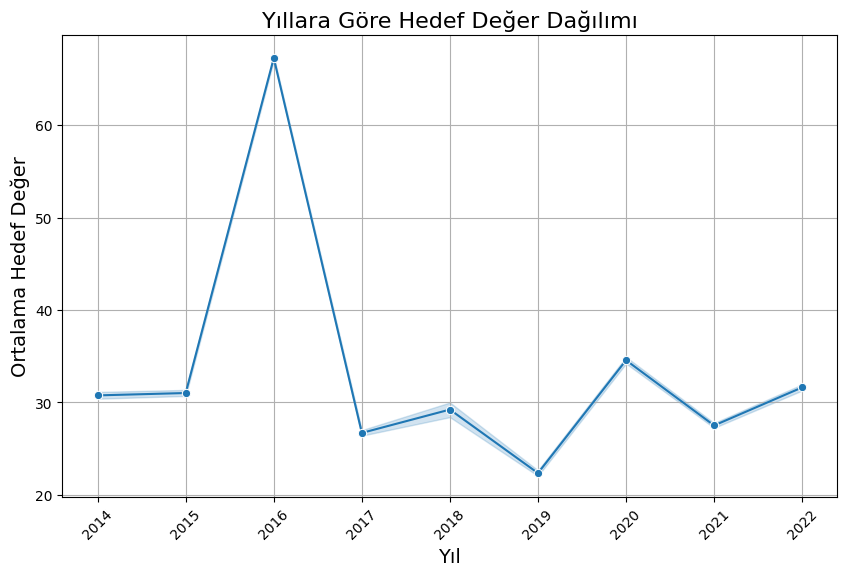

In [6]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Basvuru Yili', y='Degerlendirme Puani', data=train, marker='o')

# Grafik başlık ve etiketleri
plt.title('Yıllara Göre Hedef Değer Dağılımı', fontsize=16)
plt.xlabel('Yıl', fontsize=14)
plt.ylabel('Ortalama Hedef Değer', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

##### Eksik Veri Grafiği

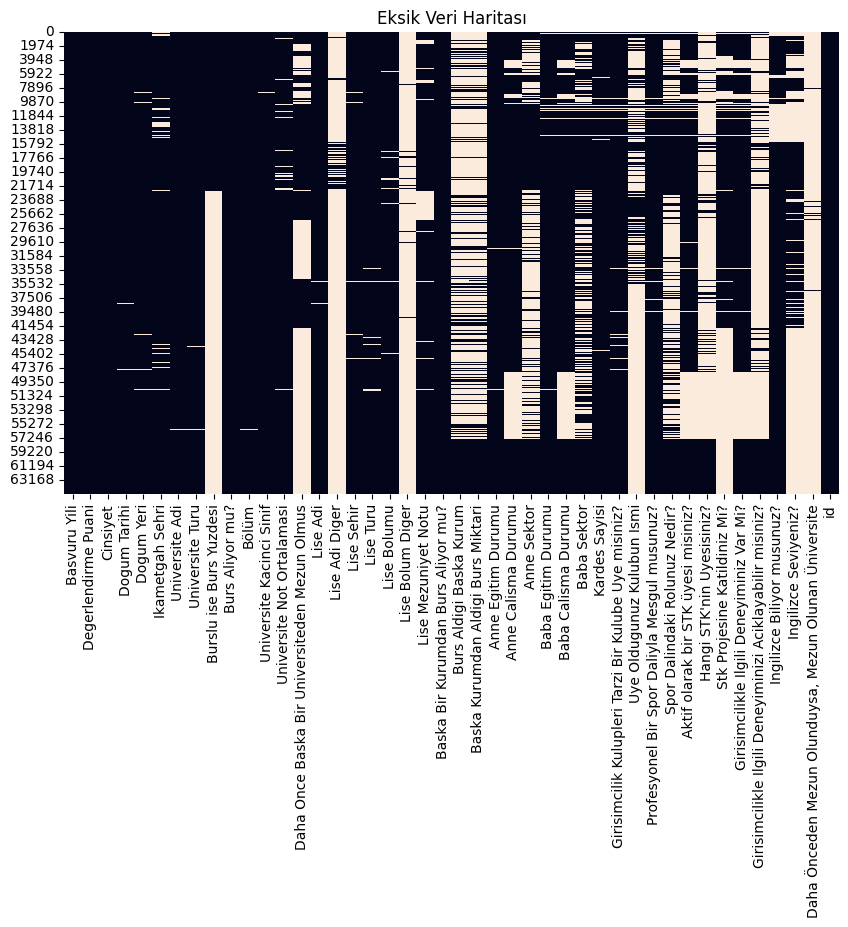

In [8]:
plt.figure(figsize=(10, 6))
sns.heatmap(train.isnull(), cbar=False)
plt.title('Eksik Veri Haritası')
plt.show()

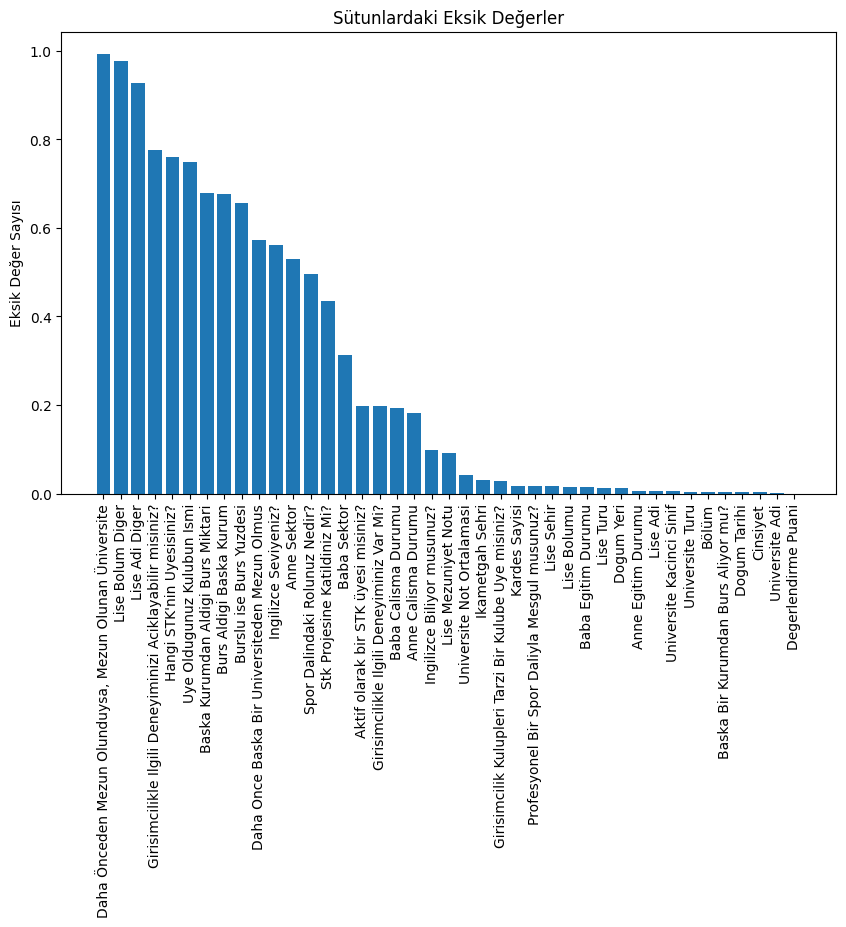

In [9]:
missing_values = train.isnull().mean()
missing_values_test = test.isnull().mean()

missing_values = missing_values[missing_values > 0]
missing_values = missing_values.sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.bar(missing_values.index, missing_values.values)
plt.xticks(rotation=90)
plt.ylabel('Eksik Değer Sayısı')
plt.title('Sütunlardaki Eksik Değerler')
plt.show()

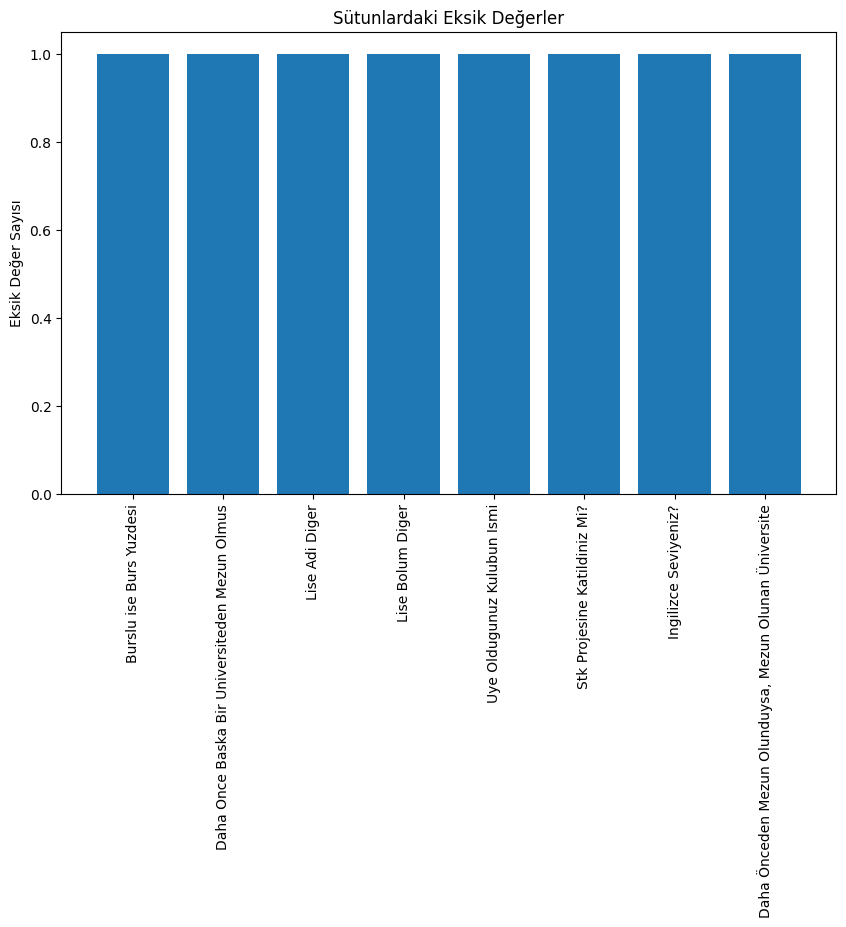

In [10]:
missing_values_test = missing_values_test[missing_values_test > 0]
missing_values_test = missing_values_test.sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.bar(missing_values_test.index, missing_values_test.values)
plt.xticks(rotation=90)
plt.ylabel('Eksik Değer Sayısı')
plt.title('Sütunlardaki Eksik Değerler')
plt.show()

##### Yüksek Eksik Veriye Sahip Olan Sütunları Silme

In [12]:
def drop_high_missing(train, test, threshold=0.7):
    # Test veri setindeki eksik veri oranını hesapla
    missing_values_test = test.isnull().mean()
    
    # Test setinde threshold'dan fazla eksik değere sahip sütunları bul
    columns_to_drop_test = missing_values_test[missing_values_test > threshold].index
    
    # Test setinde silinen sütunları train setinden de sil
    train_cleaned = train.drop(columns=columns_to_drop_test, errors='ignore')
    test_cleaned = test.drop(columns=columns_to_drop_test, errors='ignore')
    
    return train_cleaned, test_cleaned


In [13]:
train, test = drop_high_missing(train, test)
#test = drop_high_missing(test, missing_values_test)

In [14]:
train.drop(['Lise Adi', "Hangi STK'nin Uyesisiniz?", 'Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?'], axis=1, inplace=True)
test.drop(['Lise Adi', "Hangi STK'nin Uyesisiniz?", 'Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?'], axis=1, inplace=True)

In [15]:
train.shape

(65125, 33)

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11049 entries, 0 to 11048
Data columns (total 32 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Basvuru Yili                                          11049 non-null  int64  
 1   Cinsiyet                                              11049 non-null  object 
 2   Dogum Tarihi                                          11049 non-null  object 
 3   Dogum Yeri                                            11049 non-null  object 
 4   Ikametgah Sehri                                       11049 non-null  object 
 5   Universite Adi                                        11049 non-null  object 
 6   Universite Turu                                       11049 non-null  object 
 7   Burs Aliyor mu?                                       11049 non-null  object 
 8   Bölüm                                                 11

In [17]:
test.shape

(11049, 32)

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65125 entries, 0 to 65124
Data columns (total 33 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Basvuru Yili                                          65125 non-null  int64  
 1   Degerlendirme Puani                                   65124 non-null  float64
 2   Cinsiyet                                              64956 non-null  object 
 3   Dogum Tarihi                                          64948 non-null  object 
 4   Dogum Yeri                                            64334 non-null  object 
 5   Ikametgah Sehri                                       63088 non-null  object 
 6   Universite Adi                                        64993 non-null  object 
 7   Universite Turu                                       64870 non-null  object 
 8   Burs Aliyor mu?                                       65

#### Büyük Küçük Harf Duyarlılığı

In [20]:
def format_categorical_columns(df):
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        df[col] = df[col].apply(lambda x: unidecode(str(x).lower().strip()) if isinstance(x, str) else x)
        df[col] = df[col].str.replace('i̇', 'i')
    return df

In [21]:
train = format_categorical_columns(train)
test = format_categorical_columns(test)

##### Replace İşlemleri

In [23]:
replacements = {
    'ilkokul mezunu':'ilkokul',
    'ortaokul mezunu':'ortaokul',
    'egitim yok':'egitimi yok',
    'lise mezunu':'lise',
    'universite mezunu':'universite',
    'yuksek lisans / doktora':'yuksek lisans',
    'yuksek lisans / doktara':'doktora',
    '0':'egitimi yok'
}
train['Anne Egitim Durumu'] = train['Anne Egitim Durumu'].replace(replacements)
train['Baba Egitim Durumu'] = train['Baba Egitim Durumu'].replace(replacements)

In [24]:
replacements = {
    'anadolu lisesi': 'devlet',
    'diger': 'devlet',
    'duz lise': 'devlet',
    'meslek':'devlet',
    'meslek lisesi': 'devlet',
    'fen lisesi': 'devlet',
    'ozel lisesi':'ozel',
    'ozel lise':'ozel',
    'imam hatip lisesi': 'devlet'
}
train['Lise Turu'] = train['Lise Turu'].replace(replacements)

##### Yazım Hatalarını Düzeltme

In [26]:
il_ilce = pd.read_csv('ilce-listesi.csv', sep=';')

In [27]:
il_ilce.dropna(subset=['ilçe', 'il'], inplace=True)
il_ilce = format_categorical_columns(il_ilce)

In [28]:
def sehir_temizleme(df, il_ilce):
    def temizle_sehir(sehir):
        if pd.isna(sehir):
            return None
        if isinstance(sehir, str):
            sehir = sehir.strip()

            # Şehirler listesini il_ilce veri setinden alıyoruz
            sehirler = il_ilce['il'].unique()

            # Şehir listesinde kontrol et
            for il in sehirler:
                if il in sehir:
                    return il

            # Eğer şehir bulunamazsa, ilçe listesinde kontrol et
            for index, row in il_ilce.iterrows():
                if row['ilçe'] in sehir:
                    return row['il']  # İlçe bulunduysa, şehri döndür

        return None

    # Sehir temizleme işlemi uygulanan sütunlar
    df['Dogum Yeri'] = [temizle_sehir(sehir) for sehir in df['Dogum Yeri']]
    df['Ikametgah Sehri'] = [temizle_sehir(sehir) for sehir in df['Ikametgah Sehri']]
    df['Lise Sehir'] = [temizle_sehir(sehir) for sehir in df['Lise Sehir']]

    return df

# Hem train hem de test seti üzerinde çalıştırıyoruz
train = sehir_temizleme(train, il_ilce)
test = sehir_temizleme(test, il_ilce)

##### Üniversite

In [30]:
bolumler_df = pd.read_csv('bolum_listesi.csv', sep=';')
bolumler_df = format_categorical_columns(bolumler_df)
bolumler = bolumler_df.iloc[:, 0].tolist()

In [31]:
def bolum_duzelt(bolum_adi):
    if pd.isna(bolum_adi):
        return None
    if isinstance(bolum_adi, str):
        bolum_adi = bolum_adi.strip()
    
    for bolum in bolumler:
        if bolum in bolum_adi:  # Küçük-büyük harf duyarlılığını kaldırmak için
            return bolum
    return None

In [32]:
train['Bölüm'] = train['Bölüm'].apply(bolum_duzelt)
test['Bölüm'] = test['Bölüm'].apply(bolum_duzelt)

In [33]:
universite_df = pd.read_csv('universite.csv', sep=';')
universite_df = format_categorical_columns(universite_df)
universiteler = universite_df.iloc[:, 0].tolist()

In [34]:
def universite_adi_duzeltme(uni_adi):
    if pd.isna(uni_adi):
        return None
    if isinstance(uni_adi, str):
        uni_adi = uni_adi.strip()

        for uni in universiteler:
            if uni in uni_adi:
                return uni
    return None

In [35]:
train['Universite Adi'] = train['Universite Adi'].apply(universite_adi_duzeltme)
test['Universite Adi'] = test['Universite Adi'].apply(universite_adi_duzeltme)

In [36]:
replacement = {
    'hazirlik': 0.,
    'mezun': 5.,
    'yuksek lisans': 6.,
    'tez': 7.
}

train['Universite Kacinci Sinif'] = train["Universite Kacinci Sinif"].replace(replacement).astype(float)
test['Universite Kacinci Sinif'] = test['Universite Kacinci Sinif'].replace(replacement).astype(float)

In [37]:
not_ort = {
            '3.50-3': 3.25,
            '3.00-2.50': 2.75,
            '2.50 ve alti': 1.25,
            '3.00 - 4.00': 3.5,
            '3.50 - 4.00': 3.75,
            '3.00 - 3.50': 3.25,
            '2.50 -3.00': 2.75,
            'ortalama bulunmuyor': np.nan,
            '4-3.5': 3.75,
            '2.50 - 3.00': 2.75,
            '2.00 - 2.50': 2.25,
            '1.00 - 2.50': 1.75,
            'not ortalamasi yok': np.nan,
            '4.0-3.5': 3.75,
            '3.00 - 3.49': 3.25,
            '2.50 - 2.99': 2.75,
            '1.80 - 2.49': 2.25,
            'hazirligim': np.nan,
            '0 - 1.79': 1.
        }

train["Universite Not Ortalamasi"] = train["Universite Not Ortalamasi"].replace(not_ort).astype(float)
test["Universite Not Ortalamasi"] = test["Universite Not Ortalamasi"].replace(not_ort).astype(float)

##### Lise Bölüm

In [39]:
lise_bolumleri = ["sayisal", "esit agirlik", "sozel", "sosyal", "dil", "tm", "mf", "turkce-matematik",
                  "fen bilimleri", "fen", "turkce matematik", "bilisim", "matematik-fen", 
                  "fen-matematik", "ea", "turkce - matematik"]


def lise_bolumu_duzeltme(bolum_adi):
    if pd.isna(bolum_adi):
        return None  # Eğer veri eksikse None döndür
    if isinstance(bolum_adi, str):
        bolum_adi = bolum_adi.strip()  # Metni küçük harfe çevirip boşlukları temizle

        # Lise bölümleri listesinde kontrol et
        for bolum in lise_bolumleri:
            if bolum in bolum_adi:
                # Değerlerin dönüşüm tablosu (örn. "tm" -> "esit")
                bolum_donusum = {
                    "sosyal": "sozel",
                    "tm": "esit agirlik",
                    "mf": "sayisal",
                    "fen bilimleri": "sayisal",
                    "fen": "sayisal",
                    "turkce-matematik": "esit agirlik",
                    "turkce matematik": "esit agirlik",
                    "bilisim": "sayisal",
                    "matematik-fen": "sayisal",
                    "ea": "esit agirlik",
                    "turkce - matematik": "esit agirlik"
                }
                # Eğer dönüşüm tablosunda karşılığı varsa döndür
                return bolum_donusum.get(bolum, bolum)  # Karşılık yoksa aynen döndür

    return None

In [40]:
train['Lise Bolumu'] = train['Lise Bolumu'].apply(lise_bolumu_duzeltme)

In [41]:
lise_not_ort = {
            '3.50-3': 3.25,
            '3.00 - 4.00': 3.5,
            '3.00-2.50': 2.75,
            '2.50 ve alti': 1.25,
            '4.00-3.50': 3.75,
            '3.50-3.00': 3.25,
            '69-55': 1.75,
            '100-85': 3.75,
            '84-70': 2.75,
            '54-45': 1.25,
            '44-0': 0.,
            '75 - 100': 3.25,
            '50 - 75': 2.,
            'not ortalamasi yok': np.nan,
            '25 - 50': 0.75,
            '0 - 25': 0.,
            '50 - 74': 2.,
            '25 - 49': 0.5,
            '0 - 24': 0.
        }

train['Lise Mezuniyet Notu'] = train['Lise Mezuniyet Notu'].replace(lise_not_ort).astype(float)
test['Lise Mezuniyet Notu'] = test['Lise Mezuniyet Notu'].replace(lise_not_ort).astype(float)

In [42]:
def not_kategorisi(not_ortalamasi):
    if not_ortalamasi >= 3.0:
        return 'yuksek'
    elif not_ortalamasi >= 2.0:
        return 'orta'
    else:
        return 'dusuk'

def not_kategorisi_ekle(df):
    df['Universite_Not_Kategorisi'] = df['Universite Not Ortalamasi'].apply(not_kategorisi)
    df['Lise_Not_Kategorisi'] = df['Lise Mezuniyet Notu'].apply(not_kategorisi)
    return df

# Hem train hem test setine uygula
train = not_kategorisi_ekle(train)
test = not_kategorisi_ekle(test)

##### Dogum Tarihi

In [44]:
def yas_hesapla(df):
    
    df['Dogum Tarihi'] = pd.to_datetime(df['Dogum Tarihi'], errors='coerce').dt.year
    
    df['Basvuru Yasi'] = df['Basvuru Yili'] - df['Dogum Tarihi']
    
    df.loc[(df['Basvuru Yasi'] < 18) | (df['Basvuru Yasi'] > 25), 'Basvuru Yasi'] = np.NaN
    
    df.drop('Dogum Tarihi', axis=1, inplace=True)
    
    return df

train = yas_hesapla(train)
test = yas_hesapla(test)

##### Kardes Sayısı

In [46]:
train['Kardes Sayisi'] = train['Kardes Sayisi'].replace('kardes sayisi 1 ek bilgi aile hk. anne vefat', 1).astype(float)

##### Evet-Hayır

In [48]:
def evet_hayir_donusum(column):

    return column.apply(lambda x: 1 if str(x) == 'evet' 
                       else 0 if str(x) == 'hayir' 
                       else np.nan)

In [49]:
columns = ['Baska Bir Kurumdan Burs Aliyor mu?', 
           'Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?', 
           'Profesyonel Bir Spor Daliyla Mesgul musunuz?',
           'Aktif olarak bir STK üyesi misiniz?',
           'Girisimcilikle Ilgili Deneyiminiz Var Mi?',
           'Ingilizce Biliyor musunuz?'
]

for column in columns:
    train[column] = evet_hayir_donusum(train[column])
    if column in test.columns:
        test[column] = evet_hayir_donusum(test[column])

In [50]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

##### Burs Alma

In [52]:
def burs_kurumu_duzelt(df, column):
    
    df[column] = df[column].replace("-", "bos")
    df[column].fillna('bos', inplace=True)
    burs_turleri = ["kyk", "devlet", "vakf", "koc", "meb", "bakan", "derne", "gsb", "yurt", "tev", "tubitak", "bos"]
    df[column] = df[column].str.extract(f'({"|".join(burs_turleri)})', expand=False).replace({
        "yurt": "kyk", 
        "devlet": "kyk", 
        "bakan": "kyk", 
        "gsb": "kyk"
    })

    df[column].replace('bos', np.nan, inplace=True)
    
    return df

train = burs_kurumu_duzelt(train, 'Burs Aldigi Baska Kurum')
test = burs_kurumu_duzelt(test, 'Burs Aldigi Baska Kurum')

In [53]:
baska_burs_miktari = {
        '-': 0.0, 
        '0 - 499 L': 1.0,
        '500L - 999L': 2.0,
        '1000L ve ustu': 3.0
}

test['Baska Kurumdan Aldigi Burs Miktari'] = test['Baska Kurumdan Aldigi Burs Miktari'].replace(baska_burs_miktari)
train['Baska Kurumdan Aldigi Burs Miktari'] = train['Baska Kurumdan Aldigi Burs Miktari'].replace(baska_burs_miktari)

def extract_large_numbers(text):
    # Eğer değer NaN ise direkt olarak NaN döndür
    if pd.isna(text):
        return np.nan
    # Regex ile 3 veya daha fazla haneli sayıları bul
    match = re.search(r'\b\d{3,}\b', str(text))
    if match:
        return int(match.group())  # Eşleşen sayıyı döndür
    return np.nan

train['Baska Kurumdan Aldigi Burs Miktari'] = train['Baska Kurumdan Aldigi Burs Miktari'].apply(extract_large_numbers)

##### Anne - Baba Sektor

In [55]:
parent_sector = {
    '-': np.nan,
    '0': np.nan,
}
train['Anne Sektor'] = train['Anne Sektor'].replace(parent_sector)
test['Baba Sektor'] = test['Baba Sektor'].replace(parent_sector)

##### Spor

In [57]:
spor_dali = {
    '-': np.nan,
    '0': np.nan,
    'kaptan / lider': 'kaptan',
    'lider/kaptan': 'kaptan',
    'bireysel spor': 'bireysel'
}
train['Spor Dalindaki Rolunuz Nedir?'] = train['Spor Dalindaki Rolunuz Nedir?'].replace(spor_dali)
test['Spor Dalindaki Rolunuz Nedir?'] = test['Spor Dalindaki Rolunuz Nedir?'].replace(spor_dali)

##### Mode ile Doldurma

In [59]:
def doldur_mode_ile(df, columns):
    for column in columns:
        if column in df.columns:
            if df[column].isnull().sum() > 0:  # Eğer eksik veri varsa
                mode_degeri = train[column].mode()[0]  # Sütunun en sık geçen değerini al
                df[column].fillna(mode_degeri, inplace=True)  # Eksik değerleri doldur
    return df

columns = ['Cinsiyet', 'Universite Turu', 'Lise Turu', 'Anne Egitim Durumu', 'Stk Projesine Katildiniz Mi?',
           'Baba Egitim Durumu', 'Dogum Yeri', 'Ikametgah Sehri', 'Lise Sehir',
           'Universite Adi', 'Bölüm', 'Lise Bolumu', 'Baska Bir Kurumdan Burs Aliyor mu?',
           'Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?', 'Profesyonel Bir Spor Daliyla Mesgul musunuz?', 
           'Aktif olarak bir STK üyesi misiniz?', 'Girisimcilikle Ilgili Deneyiminiz Var Mi?',
           'Ingilizce Biliyor musunuz?',
           'Burs Aldigi Baska Kurum', 'Anne Calisma Durumu', 'Baba Calisma Durumu',
           'Anne Sektor', 'Baba Sektor', 'Lise Mezuniyet Notu', 'Spor Dalindaki Rolunuz Nedir?',
           'Universite Kacinci Sinif'
]

train = doldur_mode_ile(train, columns)
test = doldur_mode_ile(test, columns)

##### Medyan İle Doldurma

In [61]:
def doldur_median_ile(df, columns):
    for column in columns:
        if column in df.columns:
            if df[column].isnull().sum() > 0:
                mode_degeri = train[column].median()
                df[column].fillna(mode_degeri, inplace=True)
    return df

columns = ['Universite Not Ortalamasi', 'Lise Mezuniyet Notu', 'Basvuru Yasi',
           'Burslu ise Burs Yuzdesi', 'Baska Kurumdan Aldigi Burs Miktari',
           'Kardes Sayisi', 'Degerlendirme Puani'
]

train = doldur_median_ile(train, columns)
test = doldur_median_ile(test, columns)

In [62]:
le = LabelEncoder()

object_columns = train.select_dtypes(include='object')

# Kategorik bir sütunu sayısal değerlere dönüştür
for col in object_columns:
    # Önce train setini encode ediyoruz
    train[col] = le.fit_transform(train[col].astype(str))
    
    # Test setindeki etiketlerin, train'deki etiketlerle uyumlu olması için yeni değerleri kontrol ediyoruz
    test[col] = test[col].apply(lambda x: x if x in le.classes_ else 'unknown')
    
    # 'unknown' sınıfını numpy kullanarak LabelEncoder sınıfına ekliyoruz
    le.classes_ = np.append(le.classes_, 'unknown')
    
    # Test setini encode ediyoruz
    test[col] = le.transform(test[col].astype(str))

In [63]:
X = train.drop('Degerlendirme Puani', axis=1)
y = train['Degerlendirme Puani']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =42)

In [65]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

# Test setindeki sayısal sütunları ölçeklendirelim
X_test_scaled = scaler.transform(X_test)

In [66]:
pd.set_option('display.max_colwidth', None)

models = {
    'Linear Regression': (LinearRegression(), {}),
    'Ridge Regression': (Ridge(), {
        'alpha': [0.01, 0.1, 1, 10]
    }),
    'Gradient Boosting Regressor': (GradientBoostingRegressor(), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7]
    }),
    'Random Forest Regressor': (RandomForestRegressor(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }),
    'Extra Trees Regressor': (ExtraTreesRegressor(), {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20]
    }),
    'AdaBoost Regressor': (AdaBoostRegressor(), {
        'n_estimators': [50, 100],
        'learning_rate': [1.0, 1.5]
    }),
    'Decision Tree Regressor': (DecisionTreeRegressor(), {
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5]
    }),
    'K Neighbors Regressor': (KNeighborsRegressor(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }),
    'Dummy Regressor': (DummyRegressor(strategy='mean'), {}),
    'Extreme Gradient Boosting': (xgb.XGBRegressor(), {
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1]
    }),
    'Light Gradient Boosting Machine': (lgb.LGBMRegressor(), {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1]
    }),
    'CatBoost Regressor': (CatBoostRegressor(learning_rate=0.1, depth=6, iterations=500, verbose=0), {}),
    'Hist Gradient Boosting Regressor': (HistGradientBoostingRegressor(), {
        'max_iter': [100, 200],
        'max_depth': [3, 5]
    }),
}

results = {}

rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Her model için GridSearchCV uygulama
for name, (model, params) in models.items():
    if params:  # Eğer hiperparametreler varsa
        grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, 
                                   scoring=rmse_scorer, n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        
        # RMSE hesaplama
        rmse_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring=rmse_scorer)

        results[name] = {
            'Best Params': best_params,
            'Best Score (RMSE)': best_score,
            'Mean RMSE': rmse_scores.mean(),
            'Std Dev (RMSE)': rmse_scores.std()
        }
    else:
        # Hiperparametre ayarlaması gerektirmeyen modeller için basit bir değerlendirme
        rmse_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring=rmse_scorer)

        results[name] = {
            'Mean RMSE': rmse_scores.mean(),
            'Std Dev (RMSE)': rmse_scores.std()
        }

# Sonuçları DataFrame olarak oluşturma
results_df = pd.DataFrame.from_dict(results, orient='index')
print(results_df.sort_values(by='Best Score (RMSE)', ascending=False))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 52100, number of used features: 34
[LightGBM] [Info] Start training from score 32.095374
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 995
[LightGBM] [Info] Number of data points in the train set: 41680, number of used features: 34
[LightGBM] [Info] Start training from score 32.118498
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

In [67]:
model = CatBoostRegressor()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(test)

Learning rate set to 0.076461
0:	learn: 17.0962813	total: 8.14ms	remaining: 8.13s
1:	learn: 16.1669150	total: 16ms	remaining: 8s
2:	learn: 15.3213179	total: 23.6ms	remaining: 7.86s
3:	learn: 14.5671404	total: 31.2ms	remaining: 7.78s
4:	learn: 13.8907988	total: 39ms	remaining: 7.75s
5:	learn: 13.2648428	total: 46.6ms	remaining: 7.72s
6:	learn: 12.7060375	total: 54ms	remaining: 7.66s
7:	learn: 12.2087179	total: 61.5ms	remaining: 7.63s
8:	learn: 11.7597513	total: 68.9ms	remaining: 7.59s
9:	learn: 11.3649981	total: 76.9ms	remaining: 7.62s
10:	learn: 10.9965032	total: 85ms	remaining: 7.64s
11:	learn: 10.6788273	total: 93.5ms	remaining: 7.7s
12:	learn: 10.3959239	total: 101ms	remaining: 7.67s
13:	learn: 10.1126845	total: 110ms	remaining: 7.75s
14:	learn: 9.8578290	total: 118ms	remaining: 7.78s
15:	learn: 9.6469079	total: 126ms	remaining: 7.78s
16:	learn: 9.4654572	total: 140ms	remaining: 8.08s
17:	learn: 9.2824561	total: 153ms	remaining: 8.33s
18:	learn: 9.1208921	total: 161ms	remaining: 8.3

In [68]:
id_column = test['id']

submission = pd.DataFrame({
    'id': id_column,
    'Degerlendirme Puani': y_pred
})

In [69]:
submission.to_csv('submission.csv', index=False)